# Fellowship AI Application 

### By: Devon Bolen

In [ ]:
# Importing libraries
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
# Reading data in
df = pd.read_csv('IMDB Dataset.csv')

In [5]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Basic Exploratory Data Analysis

**Results of EDA**
- Total records to start: 50,000
- 2 features: One categorical, one text data.
- Value counts for sentiment field reflect that the data is equally distributed across. Each category has 25,000 records. 
- No null values in the data.
- Found and later removed 418 duplicate rows.
- Remaining records: 49,582
- Reviewed word count of sentiment values to see if the word count varied by sentiment. It does not.

**Normally with more robust datasets, I would also do the following:**
- Remove columns with single values
- Calculate percentage of unique values for each column. For those with very little percentage, I would consider removing the column or encode it. Remove columns with very low variance.
- Make sure the index is a unique identifier if not already
- Review and change datatypes (if needed)
- Rename columns (if needed)
- Perform over or under sampling of the data if it is imbalanced
- Add new columns based on data from existing columns (if the data would benefit)
- Remove test data (test entries)
- Remove null values or replace nulls with mean or median.
- Investigate outliers (boxplot, histogram for distribution). Remove outliers if necessary.
- Correlation plot, heatmap for numeric values
- Chi squared for correlating categorical variables
- Encode categorical variables if necessary

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# Summary stats
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
# Target value counts
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<AxesSubplot:>

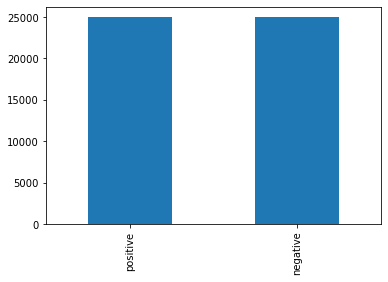

In [9]:
# Plotting value counts
df['sentiment'].value_counts()[:].plot(kind='bar')

In [10]:
df.shape

(50000, 2)

In [11]:
# Calculating total null values in features
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [12]:
# Looking at average number of words for each movie review for positive and negative reviews
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))
print(df[df['sentiment']=='positive']['word_count'].mean()) #Positive reviews
print(df[df['sentiment']=='negative']['word_count'].mean()) #Negative reviews

232.84932
229.46456


In [13]:
# Removing word_count column
df=df.drop(columns=['word_count'])

# Preprocessing

**Preprocessing involves:**
- Convert categorical variables to numeric
- Removed duplicates
- Reset index
- Lowercased text
- Removed stopwords
- Removed additional whitespace
- Removed non alphabetic characters
- Remove words with 2 characters or less. Noticed typos or words such as "br" "oz" in analysis.
- Lemmatized text

**I decided to lemmatize instead of stem for below reasons:**
- More accurate than stemming
- Keeps context by looking at structure and syntax of word to remove inflectional endings only and return the base form
- Stemming can sometimes chop off the end of the words
- In this analysis, the meaning of the word is important in predicting sentiment, therefore I would prefer to use lemmatization vs stemming in this case.

In [14]:
# Convert sentiment values to binary using sklearns label encoder.
df['label'] = label_encoder.fit_transform(df['sentiment'])

In [15]:
# Count duplicates (418)
len(df[df.duplicated()])

418

In [16]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [17]:
# Reset index
df=df.reset_index().drop(columns=['index'])

In [18]:
# Lowercasing text, replacing apostrophes with empty string, removing extra whitespace, removing stopwords, lemmatizing, removing words with only two characters
# Adding in polarity values to see if this feature adds to model performance
def preprocess(text):
    text = text.lower().replace("'","")
    text = re.sub("[^a-zA-Z]+"," ",text)
    text = re.sub(' +',' ',text)
    text = " ".join(x for x in text.split() if x not in stopwords.words('english') and len(x) > 2)
    doc = nlp(text)
    return " ".join(lemmatizer.lemmatize(w) for w in word_tokenize(text)), doc._.blob.polarity

In [19]:
# Preprocessing data
df['review_preprocessed'],df['polarity']=zip(*df['review'].apply(preprocess))

In [20]:
# Dropping irrelevant columns for modeling
newdf = df.drop(columns=['review','sentiment'])

In [21]:
newdf.head()

,label,review_preprocessed,polarity
0,1,one reviewer mentioned watching episode youll ...,0.041946
1,1,wonderful little production filming technique ...,0.125980
2,1,thought wonderful way spend time hot summer we...,0.285317
3,0,basically there family little boy jake think t...,-0.060937
4,1,petter matteis love time money visually stunni...,0.234551


# Modeling

In [182]:
# Creating the training sets. Using 80/20 to grab 80% of data for training sets.
X_train, X_rem, y_train, y_rem = train_test_split(newdf['review_preprocessed'],newdf['label'], test_size=0.2,random_state=42)

In [183]:
# Creating the validation and test sets. Using 50% test size to grab 10% data for validation and 10% of data for test.
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=42)

In [184]:
# Validating the shape of the data after splitting
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(39665,)
(39665,)
(4958,)
(4958,)
(4959,)
(4959,)


(None, None)

In [185]:
# Using TFIDF Vectorizer to fit the data. I prefer this over Count Vec because it calculates IDF to account for term importance instead of just frequency.
tfidf_vectorizer = TfidfVectorizer()
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_valid_vectors_tfidf = tfidf_vectorizer.transform(X_valid)

#### Logistic Regression

In [186]:
lr_tfidf=LogisticRegression()
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_valid_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_valid_vectors_tfidf)[:,1]

# Printing metrics
print(classification_report(y_valid,y_predict))
print('Confusion Matrix:',confusion_matrix(y_valid, y_predict))
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2498
           1       0.88      0.91      0.89      2460

    accuracy                           0.89      4958
   macro avg       0.89      0.89      0.89      4958
weighted avg       0.89      0.89      0.89      4958

Confusion Matrix: [[2179  319]
 [ 213 2247]]
AUC: 0.9592970311208315


#### Naive Bayes

In [28]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_valid_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_valid_vectors_tfidf)[:,1]

# Printing metrics
print(classification_report(y_valid,y_predict))
print('Confusion Matrix:',confusion_matrix(y_valid, y_predict))
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2498
           1       0.87      0.86      0.86      2460

    accuracy                           0.86      4958
   macro avg       0.86      0.86      0.86      4958
weighted avg       0.86      0.86      0.86      4958

Confusion Matrix: [[2179  319]
 [ 355 2105]]
AUC: 0.9370317392125083


#### K Nearest Neighbor

In [29]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_vectors_tfidf, y_train)
y_predict = classifier.predict(X_valid_vectors_tfidf)
y_prob = classifier.predict_proba(X_valid_vectors_tfidf)[:,1]

# Printing metrics
print(classification_report(y_valid,y_predict))
print('Confusion Matrix:',confusion_matrix(y_valid, y_predict))
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.83      0.71      0.77      2498
           1       0.74      0.85      0.80      2460

    accuracy                           0.78      4958
   macro avg       0.79      0.78      0.78      4958
weighted avg       0.79      0.78      0.78      4958

Confusion Matrix: [[1777  721]
 [ 358 2102]]
AUC: 0.8559807195349777


#### GBT

In [30]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.fit(X_train_vectors_tfidf,y_train)
y_predict = gradient_booster.predict(X_valid_vectors_tfidf)
y_prob = gradient_booster.predict_proba(X_valid_vectors_tfidf)[:,1]

# Printing metrics
print(classification_report(y_valid,y_predict))
print('Confusion Matrix:',confusion_matrix(y_valid, y_predict))
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      2498
           1       0.76      0.86      0.81      2460

    accuracy                           0.80      4958
   macro avg       0.80      0.80      0.80      4958
weighted avg       0.80      0.80      0.80      4958

Confusion Matrix: [[1847  651]
 [ 342 2118]]
AUC: 0.8870274268195043


**Choosing the best model:**
- Logistic regression had the highest accuracy of .89 and higher f1 score than other models. EXAPND ON THIS

In [187]:
X_test_vectors_tfidf=tfidf_vectorizer.transform(X_test)
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)      
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

In [188]:
dftest=pd.DataFrame(X_test)
dftest['label'] = y_test

In [189]:
dftest['predict_prob']= y_prob
dftest['target']= y_predict
final=dftest[['review_preprocessed','target']].reset_index(drop=True)
final.head()

,review_preprocessed,target
0,ernst lubitsch contribution american cinema en...,1
1,jason lee well give doggy movie fleeting promi...,0
2,far one worst movie ever seen poor special eff...,0
3,offensive liked movie probably never opened bi...,0
4,never felt need add review website sat film fe...,1


In [190]:
# Printing metrics for final test evaluation
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2441
           1       0.89      0.90      0.90      2518

    accuracy                           0.89      4959
   macro avg       0.89      0.89      0.89      4959
weighted avg       0.89      0.89      0.89      4959

Confusion Matrix: [[2156  285]
 [ 243 2275]]
AUC: 0.958917343671245


In [35]:
dftest.head()

,review_preprocessed,label,predict_prob,target
5411,ernst lubitsch contribution american cinema en...,1,0.989290,1
28007,jason lee well give doggy movie fleeting promi...,0,0.094542,0
22649,far one worst movie ever seen poor special eff...,0,0.000019,0
11342,offensive liked movie probably never opened bi...,0,0.056260,0
32070,never felt need add review website sat film fe...,0,0.550001,1


# Ways to improve model
- Try lemmatizing first, then stemming and see if model performance changes
- Try stemming alone
- Add more data - using Spacy library you can add entitiy labels (NER), noun chunks, polarity values, parts of speech tags and dependencies, etc. 

# Appendix

### Modeling using Polarity Values

In [181]:
# Not the most ideal feature to use for this particular dataset as a single feauture

In [ ]:
# Creating the training sets. Using 80/20 to grab 80% of data for training sets.
X_train, X_rem, y_train, y_rem = train_test_split(newdf['polarity'], newdf['label'], test_size=0.2,random_state=42)

In [ ]:
# Creating the validation and test sets. Using 50% test size to grab 10% data for validation and 10% of data for test.
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=42)

In [ ]:
X_train = np.reshape(X_train.to_list(),(-1,1))
X_valid = np.reshape(X_valid.to_list(),(-1,1))

In [ ]:
# Validating the shape of the data after splitting
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(39665,)
(39665,)
(4958,)
(4958,)
(4959,)
(4959,)


(None, None)

#### Logistic Regression

In [ ]:
lr=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr.fit(X_train1, y_train)  
#Predict y value for test dataset
y_predict = lr.predict(X_valid1)
y_prob = lr.predict_proba(X_valid1)[:,1]

# Printing metrics
print(classification_report(y_valid,y_predict))
print('Confusion Matrix:',confusion_matrix(y_valid, y_predict))
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      2498
           1       0.76      0.77      0.77      2460

    accuracy                           0.77      4958
   macro avg       0.77      0.77      0.77      4958
weighted avg       0.77      0.77      0.77      4958

Confusion Matrix: [[1907  591]
 [ 564 1896]]
AUC: 0.8396508263521386
